In [102]:
using JuMP, Clp, Plots

In [98]:
num_assets = 5
r = [ 1.0  0.3 -0.7;
      0.8  -0.3 -0.9;
      0.4   0.1 -1.0;
      0.6   0.4 0.1;
      0.1   -0.1 -0.3;]
p = [0.2,0.5,0.3]
α = 0.9

0.9

In [78]:
r[3,2]

0.3

=========== ω = 0.0 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.1 ===========
optimal solution = -0.315
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.2 ===========
optimal solution = -0.27999999999999997
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.3 ===========
optimal solution = -0.24499999999999997
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.4 ===========
optimal solution = -0.21
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.5 ===========
optimal solution = -0.175
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35
CVAR: 0.0
=========== ω = 0.6 ===========
optimal solution = -0.13999999999999999
x = [0.0, 0.0,

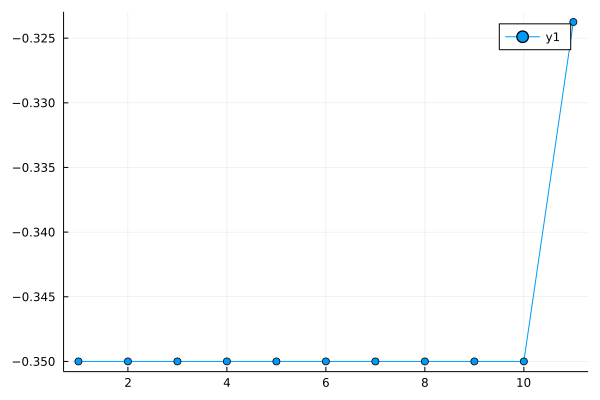

In [107]:
cvar_list = []
expected_value_list = []
for ω in 0.0:0.1:1.0
    
    model_Portifolio = Model(Clp.Optimizer)
    set_optimizer_attribute(model_Portifolio, "LogLevel",0)

    @variables(model_Portifolio,
    begin
        x[1:num_assets] ≥ 0
        l ≥ 0
        θ[1:size(p,1)] ≥ 0
    end)

    @constraints(model_Portifolio,
    begin
        ct1, sum(x[i] for i = 1:num_assets) == 1
        ct2[s=1:size(p,1)], θ[s] ≥ sum(-r[i,s]*x[i] for i = 1:num_assets) - l
    end)

    @objective(model_Portifolio, Min, (1-ω)*sum(p[s]*(sum(-r[i,s]*x[i] for i = 1:num_assets)) for s = 1:size(p,1)) + ω * (l + sum(p[s]*θ[s]/(1-α) for s = 1:size(p,1))))
    optimize!(model_Portifolio);
    
    cvar = value(l) + sum(p[s]*value(θ[s])/(1-α) for s = 1:size(p,1))
    exp_value = sum(p[s]*(sum(-r[i,s]*value(x[i]) for i = 1:num_assets)) for s = 1:size(p,1))
    
    append!(cvar_list,cvar)
    append!(expected_value_list,exp_value)
    
    println("=========== ω = $(ω) ===========")
    println("optimal solution = $(objective_value(model_Portifolio))")
    println("x = $(value.(x))")
    println("l = $(value(l))")
    println("θ = $(value.(θ))")
    println("Expected Value: $(exp_value)")
    println("CVAR: $(cvar)")
end
plot(x=cvar_list,expected_value_list, shape = :circle)

=========== γ = 0.0 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.0, 0.0]
Expected Value: -0.35)
CVAR: 0.0
=========== γ = 0.1 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.019999999999999997, 0.0]
Expected Value: -0.35)
CVAR: 0.1
=========== γ = 0.2 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.039999999999999994, 0.0]
Expected Value: -0.35)
CVAR: 0.2
=========== γ = 0.3 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.059999999999999984, 0.0]
Expected Value: -0.35)
CVAR: 0.3
=========== γ = 0.4 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.07999999999999999, 0.0]
Expected Value: -0.35)
CVAR: 0.4
=========== γ = 0.5 ===========
optimal solution = -0.35
x = [0.0, 0.0, 0.0, 1.0, 0.0]
l = 0.0
θ = [0.0, 0.09999999999999998, 0.0]
Expected Value: -0.35)
CVAR: 0.5
=========== γ = 0.6 =========

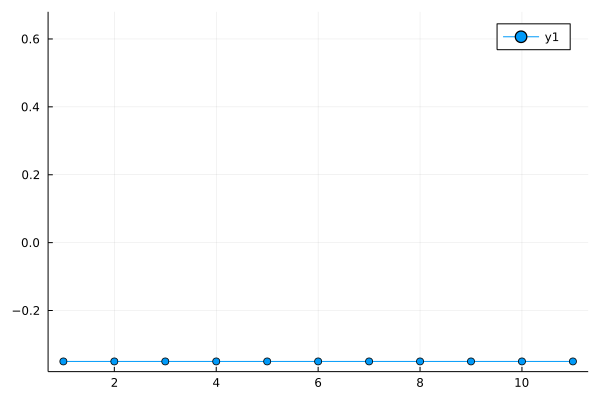

In [106]:
cvar_list = []
expected_value_list = []
for γ in 0.0:0.1:1.0
    
    model_Portifolio = Model(Clp.Optimizer)
    set_optimizer_attribute(model_Portifolio, "LogLevel",0)

    @variables(model_Portifolio,
    begin
        x[1:num_assets] ≥ 0
        l ≥ 0
        θ[1:size(p,1)] ≥ 0
    end)

    @constraints(model_Portifolio,
    begin
        ct1, sum(x[i] for i = 1:num_assets) == 1
        ct2[s=1:size(p,1)], θ[s] ≥ sum(-r[i,s]*x[i] for i = 1:num_assets) - l
        ct3, l + sum(p[s]*θ[s]/(1-α) for s = 1:size(p,1)) ≤ γ
    end)

    @objective(model_Portifolio, Min, sum(p[s]*(sum(-r[i,s]*x[i] for i = 1:num_assets)) for s = 1:size(p,1)))
    optimize!(model_Portifolio);
    
    cvar = value(l) + sum(p[s]*value(θ[s])/(1-α) for s = 1:size(p,1))
    exp_value = sum(p[s]*(sum(-r[i,s]*value(x[i]) for i = 1:num_assets)) for s = 1:size(p,1))
    
    append!(cvar_list,cvar)
    append!(expected_value_list,exp_value)
    
    println("=========== γ = $(γ) ===========")
    println("optimal solution = $(objective_value(model_Portifolio))")
    println("x = $(value.(x))")
    println("l = $(value(l))")
    println("θ = $(value.(θ))")
    println("Expected Value: $(exp_value))")
    println("CVAR: $(cvar)")
end

plot(x=cvar_list,expected_value_list, shape = :circle)